# Extracellular

## Example: Recording Extracellular Local Field Potentials (LFPs)

A part of BioNet's built-in functionality is the ability to record extra-cellular Local Field Potentials (LFPs) from morphologically detailed networks of cells. Like with in-vivo experiments, it involves placing one or more electrodes by the cells that will pick up the change of the extracellular potentials throughout the experiment/simulation. This can be useful for comparing simulations to real experiment recordings taken from a M.E.A, neuronal probe, or even ECoG or EEG. It can also be used to calculate the current-source densities, thus capturing the slow-reacting non-spiking dynamics of your network.

<br>
<div class="admonition note" name="html-admonition" style="background: lightgreen; padding: 10px">
Potential Restrictions
</div>
<br>

BMTK only supports capturing the LFPs for `biophysical` **model_type** cells. It will not work in PointNet since these are point-neuron cells (and many of the models are not conductance-based), so at the moment, BMTK does not have the ability to estimate segment membrane potential. Nor will it work with BioNet/NEURON `point-neuron` models. If a network contains a mix of both `biophysical` and `poinet-neuron` models, then the `point-neuron` models will be ignored when collecting extracellular recordings.

Also, **NOTE** that adding extracellular potential recordings to your network is computationally expensive. Expect simulations to take significantly longer than they would if you were just recording spikes or even membrane voltages.


### Step 1: Building a Network (Caveats)

Creating a network that is capable of recording LFPs is no different than the way you would normally create a SONATA-based network. And most of the time, we can dynamically add a recording electrode before any simulation. However, there are some requirements that we must be cognizant of:

1. Our network **MUST** have attributes **x**, **y**, **z** defined for all cells being recorded by our electrode (s). Variables like spiking events or membrane potential are spatially invariant, so the exact coordinates of each cell of the network are not required. With extracellular recordings, the distance between the cells and electrodes will be very important in determining LFP.
2. You should also take care that **rotation_angle_xaxis**, **rotation_angle_yaxis**, and **rotation_angle_zaxis** are set properly. Especially if the cell is bipolar-like in morphology, it can make a big difference. However, if you want to use the default morphology from the *swc*, *asc*, *hoc*, etc, then not specifying the **rotation_angles** will just default rotations to 0.0

In this example, we build our network cells like such:
```python
x, y, z = get_coords(20, y_range=[-300, -100])
cortcol.add_nodes(
    N=20,

    # Reserved SONATA keywords used during simulation
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    model_processing='aibs_perisomatic',
    dynamics_params='Scnn1a_485510712_params.json',
    morphology='Scnn1a_485510712_morphology.swc',

    # The x, y, z locations and orientations (in Euler angles) of each cell
    # Here, rotation around the pia-to-white-matter axis is randomized
    x=x,
    y=y,
    z=z,
    rotation_angle_xaxis=0,
    rotation_angle_yaxis=np.random.uniform(0.0, 2 * np.pi, size=20),
    rotation_angle_zaxis=3.646878266,

    tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
    layer='L23',
    model_name='Scnn1a',
    ei='e'
)
```

In this particular example, we use a very simplified "cortical column" consisting of layers `L2/3`, `L4` (which receives most of the network inputs), and `L5` pyramidal cells surrounded by inhibitory interneurons. The cells are built in a column parallel to the **y** axis and centered at **x=0** and **z=0**. 

We can use VND to visualize our network to make sure the layering and rotation of our cells are correct:

<br>
<div>
  <img src="../images/lfp_cortcol_small.png" width="500" align="center" style="margin-left:5px"/>    
</div>
<br clear="left">

The full script for this example can be found in the file *build_network.lfp.py*. We encourage you to make changes and test out the effects different cell types, synapses, and geometry have on LFP recordings. You can also try using a different network altogether.


### Step 2: Adding "ecp" recordings to simulation config.

The next step is to open up our SONATA simulation configuration file (*config.lfp.json*) so that it contains the following in the "reports" section.

```json
"reports": {
    "cortical_electrode": {
        "module": "extracellular",
        "variable_name": "v",
        "cells": "all",
        "electrode_positions": "./components/electrodes/linear_electrode.csv",
        "electrode_channels": "all"
    }
}
```
* The **module** should always be set to value `extracellular`, which tells BMTK what type of recording to apply.
* The **variable_name** should be set to `v`, which is the voltage just outside of every compartment membrane.
* Setting **cells** to all tells BMTK to record the extracellular potential of all (biophysical) cells in the model. You can use the [node_set]() to select only a portion of cells to record from. For example, if you wanted to filter by specific node-ids:
```json
    "cells": {
        "population": "cortcol",
        "node_ids": [0, 100, 200, 300]
    },
```
&nbsp;&nbsp;&nbsp;&nbsp; or if you wanted to record from Layer 4 excitatory cells
```json
    "cells": {
        "layer": "L4",
        "ei": "e"
    },
```
* **electrode_positions** will point to the csv file containing recording electrodes (see below)
* We set **electrode_channels** to `all` to indicate the use of all possible electrodes in the electrodes csv file.



### Step 3: Creating electrodes file

We must tell BioNet the location of all recording electrodes, which we specify in the file *./componets/electrodes/linear_electrodes.csv*. This is a simple space-separated file where each line represents the `channel_id`, `x`, `y`, and `z` position for each channel that will be recording ecp from.

In [3]:
import pandas as pd

pd.read_csv('components/electrodes/linear_electrode.csv', sep=' ')

,channel,x_pos,y_pos,z_pos
0,0,0.0,0.0,0.0
1,1,0.0,-100.0,0.0
2,2,0.0,-200.0,0.0
3,3,0.0,-300.0,0.0
4,4,0.0,-400.0,0.0
5,5,0.0,-500.0,0.0
6,6,0.0,-600.0,0.0
7,7,0.0,-700.0,0.0
8,8,0.0,-800.0,0.0


In this example, an electrode array placed straight down the column will record the LFP at every 100-micron interval. Like with the placement of cells, we can use whatever coordinate framework for placing our network. In this case, we assume our column is centered at the axis. However, we could also use a global framework like the [CCF](https://biccn.org/standards/common-coordinate-frameworks-biccn). The important thing for BMTK is that the electrodes and cells must be in the same coordinate system. 

### Step 4: Running the simulation

Now that we've updated our simulation configuration accordingly, we can run the simulation like we normally would (be mindful that it will likely take longer and use more resources than normal):


In [4]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.lfp.json')
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2024-05-06 16:44:47,725 [INFO] Created log file
2024-05-06 16:44:47,800 [INFO] Building cells.
2024-05-06 16:44:54,079 [INFO] Building recurrent connections
2024-05-06 16:44:56,795 [INFO] Building virtual cell stimulations for virt_exc_spikes
2024-05-06 16:45:02,063 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-05-06 16:45:02,064 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-06 16:45:02,065 [INFO] Block save every 5000 steps
2024-05-06 16:48:45,005 [INFO]     step:5000 t_sim:500.00 ms
2024-05-06 16:52:23,824 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-06 16:56:20,091 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-06 17:00:13,828 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-06 17:00:13,881 [INFO] Simulation completed in 15.0 minutes, 11.82 seconds 


### Step 5: Analyzing the results

The `bmtk.analyzer.ecp` package of BMTK includes a number of tools for analyzing and visualizing the results of the electrode recordings:


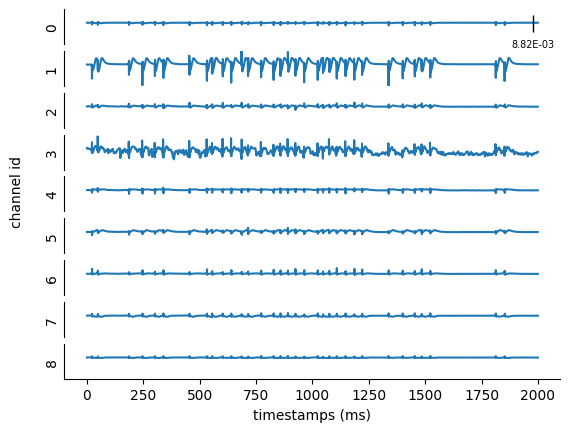

In [5]:
from bmtk.analyzer.ecp import plot_ecp

_ = plot_ecp(config_file='config.lfp.json', report_name='cortical_electrode')

But if you need to analyze the results yourself, they will be saved in the *output/cortical_electrode.h5* file, which is an HDF5 following SONATA format for [Extracellular reports](https://github.com/AllenInstitute/sonata/blob/master/docs/SONATA_DEVELOPER_GUIDE.md#extracellular-report). The results are stored in the `/ecp/data` table that is $T-timestamps x N-channels$ in size.


<br>
<div>
  <img src="../images/hdf5_ecp_format.png" width="500" align="center" style="margin-left:5px"/>    
</div>
<br clear="left">


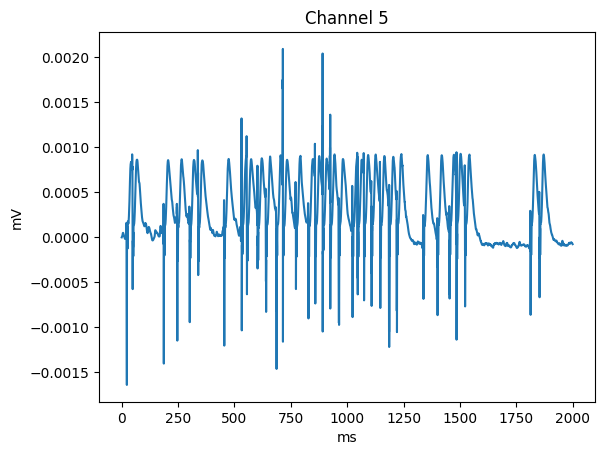

In [18]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

channel_id = 5

with h5py.File('output_lfp/cortical_electrode.h5', 'r') as h5:
    channel_idx = np.argwhere(h5['/ecp/channel_id'][()] == channel_id).flatten()
    ts = np.arange(start=h5['/ecp/time'][0], stop=h5['/ecp/time'][1], step=h5['/ecp/time'][2])
    plt.plot(ts, h5['/ecp/data'][:, channel_idx])
    plt.title(f'Channel {channel_id}')
    plt.xlabel(h5['/ecp/time'].attrs['units'])
    plt.ylabel(h5['/ecp/data'].attrs['units'])

### (Optional) Finding individual contributions

When each channel in the electrode calculates the ECP at each given time, it does so by taking the extracellular Vm of each cell, adjusting for distance and interstitual resistance, and summing the results over all recorded cells. 

Sometimes, for deeper analysis of a simulation, you may want to measure the individual contribution each cell has on the electrode. To do so in our simulation we just need to add the **contributions_dir** option to the simulation configuration:

```json
"reports": {
    "cortical_electrode": {
        "module": "extracellular",
        "variable_name": "v",
        "cells": "all",
        "electrode_positions": "./components/electrodes/linear_electrode.csv",
        "electrode_channels": "all",
        "contributions_dir": "cell_contributions"
    }
}
```

Now, when you run the simulation, it will add an extra directory *output_lfp/cell_contributions/* that will contain N SONATA Extracellular reports for each N individual cell (The file name of each h5 will correspond to the node_id of each cell).

Be **WARNED** that adding the "contributions_dir" option will take up a lot of disk space for even moderately sized networks. Feel free to edit *config.lfp.json* and see how different cells and cell-types differ in their LFP signatures.


## Example: Modifying Extracellular Resistance

## Example: Calculating the Current Source Density (CSD)